In this project, I will analyze the results of an A/B test for the game Cookie Cats developed by Tactile Entertainment. The objective of the game is to connect three items in a line and clear the board to beat the level. As players progress through the levels, they will occasionally encounter gates where they will either have to wait a certain amount of time or make an in-app purchase to progress further. The goal of this project is to compare the difference of effects of setting the first gate at level 30 or level 40 on 1 and 7 day retention and number of rounds played.

In [1]:
# Import Pandas, Matplotlib and Seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data and show the first few lines
test_data = pd.read_csv('datasets/cookie_cats.csv')
test_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


This dataset is originally from a DataCamp project, and here's its description:

<blockquote><p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.</blockquote>

The data tracks players for 14 days after the game installation with the columns indicating the player ID, test group they were assigned (gate 30 or 40), total number of rounds played (NOT levels passed), and whether the player returned 1 day or 7 days after installing the game.  

For the purposes of the analysis, there is an important assumption about the last two variables that I will make: ```retention_1``` and  ```retention_7``` indicate whether the player returned exactly 1 and 7 days after the installation respectively and nothing else. We can't use that information to infer any kind of playing habit. For all we know, a player could have played everyday during the 14 days except days 1 and 7, and the data will show ```False``` for those two variables, just like someone could have played a single round on day 7 and uninstalled the game, and the data will show ```False``` for ```retention_1``` and ```True``` for ```retention_7``` for that user.

Another assumption I will make is that all the players that downloaded the game during the test period were tracked for 14 days after the installation no matter when exactly they installed the game.

For the first step, let's use Panda's ```.info()``` method to check the data for missing values.

In [2]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


There are no missing values, so we can move on.  

One thing about this dataset is that even though we know which player was assgined to what group, we don't know if they actually experienced the feature since we don't know what was the furthest level they reached while the data was recorded.The only approximation we have is ```sum_gamerounds```, so I'll explore that next.

Let's look at the far end first and check out the players with 15 most rounds played.

In [3]:
# Sort test_data by sum_gamerounds in descending order and return the top 15
test_data.sort_values(by='sum_gamerounds', ascending=False).head(15)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True


A few observations:
- From the 15 players with most rounds played, 10 played over 2000 rounds.
- The highest number or rounds played is 49,845! That's 3561 per day if we assume those rounds were played over a 14-day span! (Value for ```retention_1``` is ```False``` in that row, so it must have taken less than 14 days.)
- There's no other player with over 3,000 total rounds played.

The highest number is an outlier (perhaps a glitch or someone trained a bot to play for them), so it would make sense to drop it from the data if I want to compare numbers of rounds played between groups later.

In [4]:
# Drop the value at index 57702
test_data.drop(57702, inplace = True)

Let's check out how many players have played over 500 rounds total, or more than 35 rounds per day assuming they played for the whole 14 days.

In [5]:
# Get rows with values more than 500 for sum_gamerounds, group by version, and count the rows 
test_data.query('sum_gamerounds > 500').groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,426,426,426,426
gate_40,429,429,429,429


There are 855 players, less than 1% of the total, with more than 500 rounds played.

In the next step, let's check out the distribution of players who played 200 rounds or less by plotting a histogram.

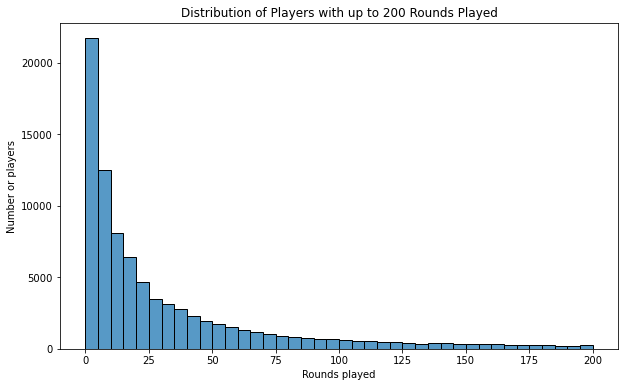

In [6]:
# Set figure size for better visibility
plt.figure(figsize=(10,6))

# Plot the distribution histogram with bin width of 5 and set labels
sns.histplot(data=test_data, x = 'sum_gamerounds', binwidth = 5, binrange = (0, 200))
plt.title('Distribution of Players with up to 200 Rounds Played')
plt.xlabel('Rounds played')
plt.ylabel('Number or players');

A good chunk of players stopped playing before completing 30 rounds. Let's zoom in on them.

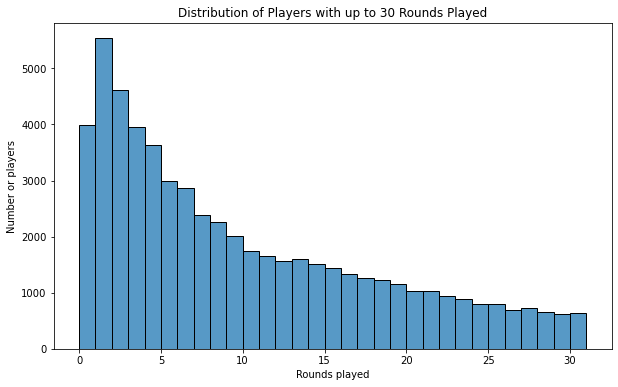

In [7]:
# Set figure size for better visibility
plt.figure(figsize=(10,6))

# Subset the data
data=test_data.query('sum_gamerounds < 31')

# Plot the distribution histogram with bin width of 1 and set labels
# Binrange is set to (0, 31), otherwise seaborn stacks bins 29 and 30
sns.histplot(data=data, x = 'sum_gamerounds', binwidth = 1, binrange = (0, 31))
plt.title('Distribution of Players with up to 30 Rounds Played')
plt.xlabel('Rounds played')
plt.ylabel('Number or players');

Looks like about 4,000 users intalled the game but never played a single round. We can drop them from the dataset.

In [8]:
test_data.drop(test_data.query('sum_gamerounds == 0').index, inplace = True)
print(f'Remaining number of rows: {len(test_data)}')

Remaining number of rows: 86194


(I take a bit of a probability detour here that does not impact the analysis, so you can skip this cell and the next two plots if you'd like.)  

As I mentioned earlier, the dataset does not tell us whether a player actually experienced the feature or not since we don't know how many levels they completed, and the closest approximation we have is the number of rounds they played. So, the more rounds they played, the higher the likelihood they played enough to reach levels 30 and 40.

We can model that probability using binomial distribution.  

If we have
$$
p = \text{probability of beating a level,}\\
n = \text{number of rounds played,}\\
k = \text{number of successful rounds,}\\  
$$
then the probability of beating $k$ levels in $n$ rounds played is given by  

$$
\mathbb{P}(X=k)=\binom{n}{k}p^k(1-p)^{n-k}=\frac{n!}{k!(n-k)!}p^k(1-p)^{n-k}
$$  

and the probability of beating $\textbf{k}$ **or more** levels in $n$ rounds is  
$$
\mathbb{P}(X\geq k)=\mathbb{P}(X=k)+\mathbb{P}(X=k+1)\,+\,...\,+\,\mathbb{P}(X=n)=\sum_{i=k}^{n}\binom{n}{i}p^i(1-p)^{n-i}
$$  
Furthermore,  
$$
\mathbb{P}(X\geq k)=1-\mathbb{P}(X\leq k)+\mathbb{P}(X=k)
$$  
where $\mathbb{P}(X\leq k)$ is the cumulative distribution function and $\mathbb{P}(X=k)$ is the probability mass function of $X$.  

To help visualize how probability of beating a certain number of levels increases with the number of rounds played, I'll plot $\mathbb{P}(X\geq k|n,p)$ with $k=30$, $n=100$, and $p\in\{0.25, 0.5, 0.75, 1\}$.

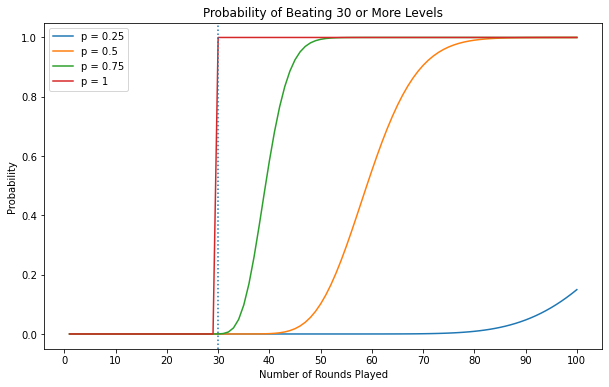

In [9]:
# Import scipy.stats.binom to use cdf and pmf functions instead of calculating things manually
from scipy.stats import binom

# Set figure size for better visibility
plt.figure(figsize=(10,6))

# Plot lines for p = 0.25, 0.5, 0.25, and 1 (k=30, n=100 for all 4)
sns.lineplot(x = range(1,101), y = [1-binom.cdf(30, x, 0.25)+binom.pmf(30, x, 0.25) for x in range(1, 101)])
sns.lineplot(x = range(1,101), y = [1-binom.cdf(30, x, 0.5)+binom.pmf(30, x, 0.5) for x in range(1, 101)])
sns.lineplot(x = range(1,101), y = [1-binom.cdf(30, x, 0.75)+binom.pmf(30, x, 0.75) for x in range(1, 101)])
sns.lineplot(x = range(1,101), y = [1-binom.cdf(30, x, 1)+binom.pmf(30, x, 1) for x in range(1, 101)])

# Add a vertical line at 30 rounds played and adjust X-axis ticks
plt.axvline(30, linestyle = ':')
plt.xticks(range(0, 101, 10))

# Set legend, title, and axis labels
plt.legend(labels = ['p = 0.25', 'p = 0.5', 'p = 0.75', 'p = 1'])
plt.title('Probability of Beating 30 or More Levels')
plt.xlabel('Number of Rounds Played')
plt.ylabel('Probability');

Let's also make a similar plot for 40 rounds.

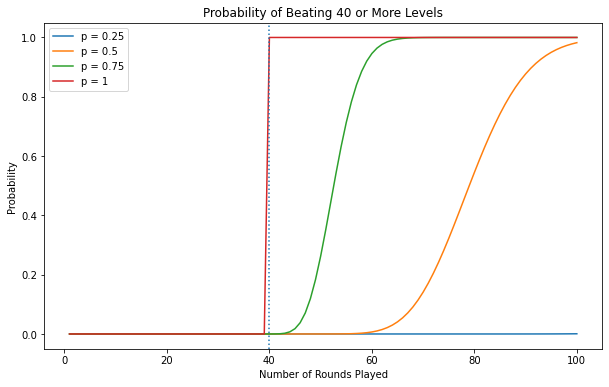

In [10]:
# Set figure size for better visibility
plt.figure(figsize=(10,6))

# Plot lines for p = 0.25, 0.5, 0.25, and 1 (k=30, n=100 for all 4)
sns.lineplot(x = range(1,101), y = [1-binom.cdf(40, x, 0.25)+binom.pmf(40, x, 0.25) for x in range(1, 101)])
sns.lineplot(x = range(1,101), y = [1-binom.cdf(40, x, 0.5)+binom.pmf(40, x, 0.5) for x in range(1, 101)])
sns.lineplot(x = range(1,101), y = [1-binom.cdf(40, x, 0.75)+binom.pmf(40, x, 0.75) for x in range(1, 101)])
sns.lineplot(x = range(1,101), y = [1-binom.cdf(40, x, 1)+binom.pmf(40, x, 1) for x in range(1, 101)])

# Add a vertical line at 40 rounds played
plt.axvline(40, linestyle = ':')
# Set legend, title, and axis labels
plt.legend(labels = ['p = 0.25', 'p = 0.5', 'p = 0.75', 'p = 1'])
plt.title('Probability of Beating 40 or More Levels')
plt.xlabel('Number of Rounds Played')
plt.ylabel('Probability');

(Back to the analysis.)  

Since we don't know our population $p$ value, 30 rounds played is an important benchmark because it will take a player that was assigned to the group 'gate_30' at least 30 rounds to beat 30 levels to reach the gate. Also, since the features of the gates for both groups are the same (same wait time or in-app purchase price), we are measuring the effect of the 10 level difference, and not the gates themselves.  

Another point to consider is that the high dropout rate after very few rounds played is most likely due to the players not having enough interest in the game itself, and the location of the gates probably makes no difference.    

Typically, including players that never experienced a feature in calculations would be similar to measuring the effectiveness of a drug by using participants who were assigned to the experimental group without actually being administered the drug. However, since I don't know the exact format of the experiment, there might have been an effect on player behavior caused by them simply being in a certain group. For example, if seeing a gate affects overall motivation levels of a player to continue playing, players in ```gate_30``` group would get that "motivation boost/drop" sooner than players in ```gate_40``` and it could affect behavior of players who never reached the gate. On the other hand, the two versions could be visually identical and the feature would turn on only after beating the appropriate level. 

Using that as my reasoning, I will create a subset of the dataset with players who played at least 30 rounds, do the same comparisons between groups on the subset and the dataset, and see if there are any interesting insights.

In [11]:
# Remove all rows with less than 30 rounds played from test_data in-place
test_data_30 = test_data.drop(test_data.query('sum_gamerounds < 30').index)

Let's check ```test_data_30``` to make sure the drop went smoothly.

In [12]:
print('Players with less than 30 rounds played:')
display(test_data_30.query('sum_gamerounds < 30').head())
print('\nPlayers with less than 31 rounds played:')
test_data_30.query('sum_gamerounds < 31').head()

Players with less than 30 rounds played:


,userid,version,sum_gamerounds,retention_1,retention_7



Players with less than 31 rounds played:


,userid,version,sum_gamerounds,retention_1,retention_7
12,2132,gate_40,30,True,False
338,33954,gate_40,30,True,False
388,38249,gate_40,30,True,False
705,76662,gate_40,30,True,False
911,101864,gate_40,30,False,False


Now I have two dataframes: ```test_data``` with players who played at least 1 round, and ```test_data_30``` with players who played at least 30 rounds. Let's check both of them to see how many players we have assigned to each group.

In [13]:
display(test_data.groupby('version').count())
test_data_30.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,42762,42762,42762,42762
gate_40,43432,43432,43432,43432


,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,16655,16655,16655,16655
gate_40,16613,16613,16613,16613


There's a difference of 670 in the bigger dataset, but that won't be a problem since the samples are large. The smaller one has a difference of 42.

I'll compare ```retention_1``` by group next, but before doing that, I'll state my hypotheses (both are ```test_data``` and ```test_data_30```).  

$$H_0:\mu_{gate\_30}=\mu_{gate\_40}$$
$$H_a:\mu_{gate\_30}\ne\mu_{gate\_40}$$  

I'll use $\alpha$ = 0.05. Since the alternative hypothesis calls for a two-tailed test, it's 0.025 in each tail.

In [14]:
test_data.groupby('version')['retention_1'].mean()

version
gate_30    0.467541
gate_40    0.462171
Name: retention_1, dtype: float64

In [15]:
test_data_30.groupby('version')['retention_1'].mean()

version
gate_30    0.801021
gate_40    0.801842
Name: retention_1, dtype: float64

One-day retention rates are almost identical in ```test_data_30```, so it's safe to assume that the null hypothesis holds there. There's a 0.5% difference in the larger set. That difference is small and is unlikely to be statistically significant, but I'll check anyway.  

To do that, I'll use a two proportion Z-test given by  

$$Z=\frac{\hat{p}_{gate\_30}-\hat{p}_{gate\_40}}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_{gate\_30}}+\frac{1}{n_{gate\_40}})}}$$  

where pooled proportion $\hat{p}$ is given by  

$$\hat{p}=\frac{\hat{p}_{gate\_30}n_{gate\_30}+\hat{p}_{gate\_40}n_{gate\_40}} {n_{gate\_30} + n_{gate\_40}}$$  

and $\hat{p}_{gate\_30}$, $\hat{p}_{gate\_40}$, $n_{gate\_30}$ and $n_{gate\_40}$ refer to the proportions and samples sizes of ```gate_30``` and ```gate_40```.  

I can get the Z-score and the p-value using ```proportions_ztest``` from ```statsmodels.stats.proportion```.

In [19]:
# Import proportions_ztest and NumPy
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# Set number of positive outcomes and total numbers of observations as variables,
# pass them to proportions_ztest, and print the Z-score and the p-value 
counts = np.array(test_data.groupby('version')['retention_1'].sum())
n_obs = np.array(test_data.groupby('version')['retention_1'].count())
stat, pval = proportions_ztest(counts, n_obs)
print(f'Z-score:{stat}, p-value:{pval}')

Z-score:1.5805887864476007, p-value:0.11397209143329877


Since the p-value is greater than 0.025, we do not reject the null hypothesis. Hence, the means are equal.

Now, let's check ```retention_7```. My hypotheses are same as before.  

$$H_0:\mu_{gate\_30}=\mu_{gate\_40}$$
$$H_a:\mu_{gate\_30}\ne\mu_{gate\_40}$$

In [16]:
test_data.groupby('version')['retention_7'].mean()

version
gate_30    0.198424
gate_40    0.190321
Name: retention_7, dtype: float64

In [17]:
test_data_30.groupby('version')['retention_7'].mean()

version
gate_30    0.438727
gate_40    0.430025
Name: retention_7, dtype: float64

There are differences of 0.8% in the larger and almost 0.9% in the smaller datasets. Let's test them.

Larger dataset first.

In [20]:
# Set number of positive outcomes and total numbers of observations as variables,
# pass them to proportions_ztest, and print the Z-score and the p-value 
counts = np.array(test_data.groupby('version')['retention_7'].sum())
n_obs = np.array(test_data.groupby('version')['retention_7'].count())
stat, pval = proportions_ztest(counts, n_obs)
print(f'Z-score:{stat}, p-value:{pval}')

Z-score:3.006086884574141, p-value:0.002646333709773733


Looks like the difference in the large dataset is statistically significant with the p-value of 0.0026, which is less than 0.025. To be sure, I'll also check it with chi-square test of independence using ```scipy.stats.chi2_contingency```. 

In [27]:
from scipy.stats import chi2_contingency
obs = pd.crosstab(test_data['version'], test_data['retention_7']).to_numpy()
chi2_contingency(obs)

(8.984877907964687,
 0.0027222297777463066,
 1,
 array([[34451.60412558,  8310.39587442],
        [34991.39587442,  8440.60412558]]))

The p-value (second output) is 0.0027 which is also less than 0.025. So, looks like we will reject the null hypothesis. Just to drive it home. Let's bootstrap the data, and test the bootstrap replicates.

In [30]:
# Create a list that will hold the means of the bootstrapped samples
ret_7_boot_means = []

# Bootstrap 10,000 samples of same size as the original, calculate the retention means by group,
# and append the values to the list
for i in range(10000):
    bootstrap_mean = test_data.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    ret_7_boot_means.append(bootstrap_mean)

# Create a DataFrame from the list
ret_7_boot_means = pd.DataFrame(ret_7_boot_means)
# Create a column in the DataFrame to show the difference in retentions between versions
# for each sample as a percentage of gate_40 retention
ret_7_boot_means['difference'] =\
(ret_7_boot_means['gate_30']-ret_7_boot_means['gate_40'])/ret_7_boot_means['gate_40']*100

# Display the top few rows
ret_7_boot_means.head()

version,gate_30,gate_40,difference
retention_7,0.198632,0.191192,3.891363
retention_7,0.197362,0.192818,2.356615
retention_7,0.198576,0.187092,6.138422
retention_7,0.195280,0.187859,3.950443
retention_7,0.201390,0.189273,6.401798


What was the average difference?

In [32]:
ret_7_boot_means['difference'].mean()

4.25545590135166

Let's plot a KDE plot of the retention rate means and a histogram of the differences.

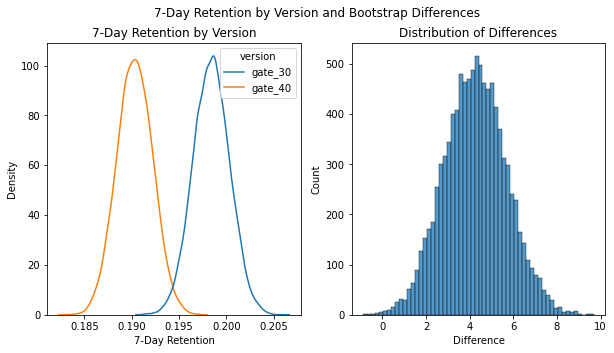

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1 = sns.kdeplot(data=ret_7_boot_means[['gate_30', 'gate_40']], ax = ax1)
ax2 = sns.histplot(data=ret_7_boot_means['difference'], ax = ax2)
fig.suptitle('7-Day Retention by Version and Bootstrap Differences')
ax1.set_title('7-Day Retention by Version')
ax1.set_xlabel('7-Day Retention')
ax2.set_title('Distribution of Differences')
ax2.set_xlabel('Difference');

And let's compute the probability of the difference being above 0, that is the probability of ```retention_7``` being greater for ```gate_30```, by calculating the fraction of the entries in ```ret_7_boot_means['difference']``` that are above 0.

In [40]:
prob = (ret_7_boot_means['difference'] > 0).mean()
print(f'Probability of difference being above 0 is {prob}')

Probability of difference being above 0 is 0.9989


As all 3 tests show, there's a statistically significant differences between 7-day retention rates between ```gate_30``` and ```gate_40```, so I will reject the null hypothesis for the larger dataset.

And now let's check ```retention_7``` in  ```test_data_30```.

In [21]:
# Set number of positive outcomes and total numbers of observations as variables,
# pass them to proportions_ztest, and print the Z-score and the p-value 
counts = np.array(test_data_30.groupby('version')['retention_7'].sum())
n_obs = np.array(test_data_30.groupby('version')['retention_7'].count())
stat, pval = proportions_ztest(counts, n_obs)
print(f'Z-score:{stat}, p-value:{pval}')

Z-score:1.601128059662799, p-value:0.10934855851569794


The p-value is 0.11 which is greater than 0.025, so there's not enough evidence to reject the null hypothesis. To be sure, I'll also test bootstrap replicates.

In [36]:
# Create a list that will hold the means of the bootstrapped samples
ret_7_boot_means_30 = []

# Bootstrap 10,000 samples of same size as the original, calculate the retention means by group,
# and append the values to the list
for i in range(10000):
    bootstrap_mean = test_data_30.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    ret_7_boot_means_30.append(bootstrap_mean)

# Create a DataFrame from the list
ret_7_boot_means_30 = pd.DataFrame(ret_7_boot_means_30)
# Create a column in the DataFrame to show the difference in retentions between versions
# for each sample as a percentage of gate_40 retention
ret_7_boot_means_30['difference'] =\
(ret_7_boot_means_30['gate_30']-ret_7_boot_means_30['gate_40'])/ret_7_boot_means_30['gate_40']*100

# Display the top few rows
ret_7_boot_means_30.head()

version,gate_30,gate_40,difference
retention_7,0.442860,0.434088,2.020714
retention_7,0.441681,0.430294,2.646187
retention_7,0.436898,0.431902,1.156730
retention_7,0.433148,0.430193,0.686940
retention_7,0.438815,0.430006,2.048517


The average difference is

In [37]:
ret_7_boot_means_30['difference'].mean()

2.021835536375284

Let's plot the retention rate bootstraps and differences as before.

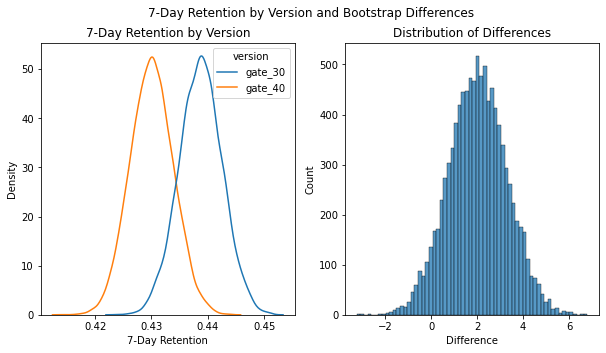

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1 = sns.kdeplot(data=ret_7_boot_means_30[['gate_30', 'gate_40']], ax = ax1)
ax2 = sns.histplot(data=ret_7_boot_means_30['difference'], ax = ax2)
fig.suptitle('7-Day Retention by Version and Bootstrap Differences')
ax1.set_title('7-Day Retention by Version')
ax1.set_xlabel('7-Day Retention')
ax2.set_title('Distribution of Differences')
ax2.set_xlabel('Difference');

And finally, I'll calculate the p-value.

In [41]:
prob = (ret_7_boot_means_30['difference'] > 0).mean()
print(f'Probability of difference being above 0 is {prob}')

Probability of difference being above 0 is 0.9445


The probability of obtaining a higher retention rate in ```group_30``` is quite high, 0.9445, but it is less than the significance level of 0.975, so we cannot reject the null hypothesis of same mean retention rates.

Lastly, I want to compare the number of rounds played. Hypotheses are still the same.  

$$H_0:\mu_{gate\_30}=\mu_{gate\_40}$$
$$H_a:\mu_{gate\_30}\ne\mu_{gate\_40}$$

In [42]:
test_data.groupby('version')['sum_gamerounds'].mean()

version
gate_30    53.667766
gate_40    53.728357
Name: sum_gamerounds, dtype: float64

The numbers are nearly identical, but I'll do a quick check for significance anyway.

In [76]:
# I'll use ztest from statsmodels.stats.weightstats
from statsmodels.stats.weightstats import ztest

# Convert sum_gamerounds for each version into an array and calculate Z-score and p-value
gate_30_rounds = test_data.query('version == "gate_30"')['sum_gamerounds'].to_numpy()
gate_40_rounds = test_data.query('version == "gate_40"')['sum_gamerounds'].to_numpy()
z, p = ztest(gate_30_rounds, gate_40_rounds)
print(f'Z-score:{z}, p-value:{p}')

Z-score:-0.0851720765870841, p-value:0.9321245895512966


As expected the p-value is 0.93, so we cannot reject the null hypothesis.

And now I'll compare the last remaining numbers, average number of rounds played in the smaller dataset.

In [73]:
test_data_30.groupby('version')['sum_gamerounds'].mean()

version
gate_30    122.092645
gate_40    124.466502
Name: sum_gamerounds, dtype: float64

There's a difference of about 2.5 rounds played. Let's check if it's significant.

In [77]:
gate_30_rounds = test_data_30.query('version == "gate_30"')['sum_gamerounds'].to_numpy()
gate_40_rounds = test_data_30.query('version == "gate_40"')['sum_gamerounds'].to_numpy()
z, p = ztest(gate_30_rounds, gate_40_rounds)
print(f'Z-score:{z}, p-value:{p}')

Z-score:-1.5205865059389807, p-value:0.1283636352206684


The p-value of 0.128 is greater than 0.025, so we cannot reject the null hypothesis.

***

Data clean-up:  
- [x] Remove right end outlier
- [x] Remove players with 0 rounds played
- [x] Create a dataset for players with 30 or more rounds played and explain why (compare the differences with bigger set/didn't play enough to contribute to the trial)


For the remaining data:  
- [ ] Decide on another approach (Z-test of 2 proportions/Chi-squre proportions test?)
- [ ] **Add hypotheses for each calculation**  
- [ ] Reorganize cells to reduce visual clutter
- [ ] Add comments and markdown cells


- [x] Calculate day 1 retention by version
- [x] Compute p-value for the hypothesis (Used proportions Z-test)  

Repeat the procedure for day 7 retention  
- [x] Calculate day 7 retention by version
- [x] Bootstrap the data 10,000 times
- [x] Plot distributions
- [x] Calculate the difference between means
- [ ] Compute p-value for the hypothesis

Repeat the procedure for rounds played  
**Might not need to do some parts if the difference is too small**
- [ ] Calculate rounds played by version
- [ ] Bootstrap the data 10,000 times
- [ ] Plot distributions
- [ ] Calculate the difference between means
- [ ] Compute p-value for the hypothesis  


- [ ] Repeat steps for the larger dataset
- [ ] Compare values